# Getting data -> (X,y) with all the features

In [1]:
# from raptor_functions.supervised.datasets import get_data
# df = get_data('handheld_data')

In [2]:
from raptor_functions.supervised.datasets import get_data
df = get_data('handheld_data')

In [3]:
df.head()

,exp_unique_id,exp_name,timesteps,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_23,sensor_24,Humidity (r.h.),measurement_stage,date_exp,time_elapsed,datetime_exp_start,datetime_exp,filename,result
0,0,Test 24,1,131.938,132.443,177.444,178.157,44.974,44.508,219.374,...,143.288,142.050,46.07,baseline,21/3/2022,0.00,14:12:54,2022-03-21 14:12:54.000,5 NegTest_3_20220321_14_12.txt,Control
1,0,Test 24,2,133.078,133.972,177.444,178.694,45.131,44.611,219.607,...,142.874,141.914,46.07,baseline,21/3/2022,0.25,14:12:54,2022-03-21 14:12:54.250,5 NegTest_3_20220321_14_12.txt,Control
2,0,Test 24,3,131.812,132.064,177.622,178.694,45.183,44.663,219.841,...,143.288,141.914,46.07,baseline,21/3/2022,0.50,14:12:54,2022-03-21 14:12:54.500,5 NegTest_3_20220321_14_12.txt,Control
3,0,Test 24,4,131.059,132.064,177.444,178.694,45.183,44.663,219.607,...,142.599,141.368,46.07,baseline,21/3/2022,0.75,14:12:54,2022-03-21 14:12:54.750,5 NegTest_3_20220321_14_12.txt,Control
4,0,Test 24,5,131.435,131.938,177.622,178.694,45.131,44.663,219.607,...,142.187,140.825,46.07,baseline,21/3/2022,1.00,14:12:54,2022-03-21 14:12:55.000,5 NegTest_3_20220321_14_12.txt,Control


In [4]:
import numpy as np
import pandas as pd
import xgboost as xgb
from boruta import BorutaPy
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import (
    ComprehensiveFCParameters,
    extract_features,
)
from tsfresh import extract_features

In [5]:
FEATURES = [
    "exp_unique_id",
    "timesteps",
    "sensor_1",
    "sensor_2",
    "sensor_3",
    "sensor_4",
    "sensor_5",
    "sensor_6",
    "sensor_7",
    "sensor_8",
    "sensor_9",
    "sensor_10",
    "sensor_11",
    "sensor_12",
    "sensor_13",
    "sensor_14",
    "sensor_15",
    "sensor_16",
    "sensor_17",
    "sensor_18",
    "sensor_19",
    "sensor_20",
    "sensor_21",
    "sensor_22",
    "sensor_23",
    "sensor_24",
]

TARGET_COL = "result"

unique_id="exp_unique_id"
label="result"
timesteps="timesteps"

In [6]:
extraction_settings = ComprehensiveFCParameters()

In [7]:
y = df.groupby(unique_id).first()[label]
X = df.drop(label, axis=1)

In [8]:
features = [col for col in X if col.startswith('sensor')]
features = [unique_id, timesteps] + features

X = X[features]

# X = df.drop(label, axis=1)
# y = df.groupby(unique_id).first()[label]

X = extract_features(
    X,
    column_id=unique_id,
    column_sort=timesteps,
    default_fc_parameters=extraction_settings,
    # we impute = remove all NaN features automatically
    impute_function=impute,
)

Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


# Function for PCA

Inputs: X, y
Outputs: plot and pandas dataframe with the 2d decomposition

In [9]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [10]:
def PCA_plot(X,y,scaler = True, plt_3D = True, figure_name = 'pca_plot', path = os.getcwd()):
    # 
    if plt_3D == True:
        n_components = 3
    else:
        n_components = 2
    pca = PCA(n_components=n_components)
    if scaler == True:
        pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
        principalComponents = pipe.fit_transform(X)
    else: 
        principalComponents = pca.fit_transform(X)
    # 
    principalDf = pd.DataFrame(data = principalComponents)
    # 
    colors = {'Control':'green', 'Covid':'red'}
    # 
    # 
    if n_components == 2:
        fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
        ax = sns.scatterplot(x=principalDf.iloc[:,0], y=principalDf.iloc[:,1], hue=y, alpha=0.9, edgecolor='black')
    elif n_components == 3:
        # 
        fig = plt.figure(figsize=(6,6))    
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)    
        cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
        sc = ax.scatter(principalDf.iloc[:,0],principalDf.iloc[:,1],principalDf.iloc[:,2], c=y.map(colors), cmap=cmap, alpha=0.9, edgecolors='black')
        ax.set_zlabel('Axis 3')
    else:
        print('Error: please only select 2 or 3 axis for the Principal Component Analysis.')
    ax.set_xlabel('Axis 1')
    ax.set_ylabel('Axis 2')
    ax.set_title('Principal Component Analysis (PCA)')
    # -----------------------------------------------------------
    # TODO: create new directory if path specified doesn't exists
    figure_name_full = figure_name + '.pdf'
    if path != os.getcwd():
        plt.savefig(path + "/" + figure_name_full, bbox_inches='tight')
        print('Plot saved sucesfully!')
    else: 
        plt.savefig(figure_name_full, bbox_inches='tight')
        print('Plot saved sucesfully!')

Plot saved sucesfully!


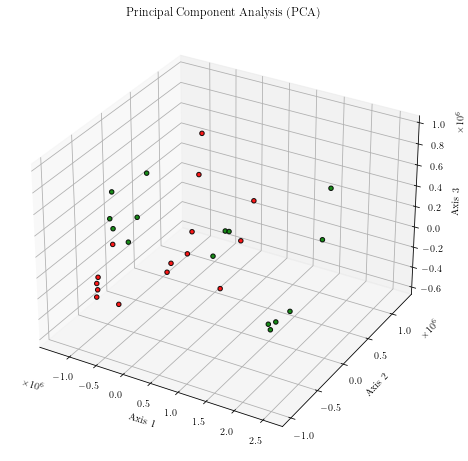

In [47]:
PCA_plot(X,y,scaler=False,plt_3D=True,figure_name = 'pca_plot_test_3d', path = '/Users/danielfiuzadosil/Documents/GitHub/raptor_functions/raptor_functions/dev/plots')

Plot saved sucesfully!


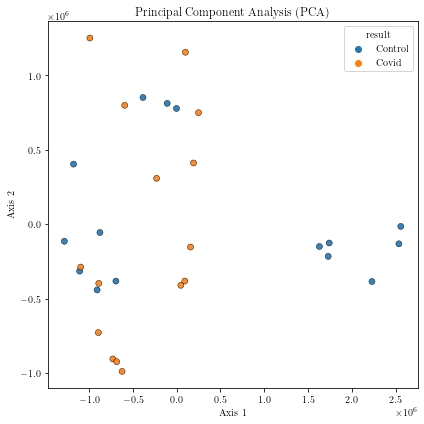

In [42]:
PCA_plot(X,y,scaler=False,plt_3D=False)

# LDA

In [12]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [13]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# lda = LinearDiscriminantAnalysis(n_components=2)
# X_r2 = lda.fit(X, y).transform(X)

In [14]:
df.reset_index(inplace=True)

In [15]:
# sns.pairplot(df, hue="result")

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# 
columns = ["var","skewness","curtosis","entropy","class"]
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/00267/\
data_banknote_authentication.txt",index_col=False, names = columns)
# 
mean_vec = []
for i in df["class"].unique():
    mean_vec.append( np.array((df[df["class"]==i].mean()[:4]) ))
print(mean_vec)
# 
SW = np.zeros((4,4))
for i in range(1,4): #2 is number of classes
    per_class_sc_mat = np.zeros((4,4))
    for j in range(df[df["class"]==i].shape[0]):
        row, mv = df.loc[j][:4].values.reshape(4,1), mean_vec[i].reshape(4,1)
        per_class_sc_mat += (row-mv).dot((row-mv).T)
    SW += per_class_sc_mat
print('within-class Scatter Matrix:\n', SW)
overall_mean = np.array(df.drop("class", axis=1).mean())
SB = np.zeros((4,4))
for i in range(2): #2 is number of classes
    n = df[df["class"]==i].shape[0]
    mv = mean_vec[i].reshape(4,1)
    overall_mean = overall_mean.reshape(4,1) # make column vector
    SB += n * (mv - overall_mean).dot((mv - overall_mean).T)
print('between-class Scatter Matrix:\n', SB)
# 
e_vals, e_vecs = np.linalg.eig(np.linalg.inv(SW).dot(SB))
print('Eigenvectors \n%s' %e_vecs)
print('\nEigenvalues \n%s' %e_vals)

[array([ 2.27668601,  4.25662719,  0.79671797, -1.14764028]), array([-1.86844256, -0.99357612,  2.14827101, -1.24664075])]
within-class Scatter Matrix:
 [[ 12894.02618964  12388.17949578  -5025.6093967    1110.90896782]
 [ 12388.17949578  34177.22271176 -12505.24344685  -4576.31987213]
 [ -5025.6093967  -12505.24344685   7858.82866205   1824.14383828]
 [  1110.90896782  -4576.31987213   1824.14383828   2876.82304762]]
between-class Scatter Matrix:
 [[ 5.82112206e+03  7.37300999e+03 -1.89802442e+03  1.39029178e+02]
 [ 7.37300999e+03  9.33862504e+03 -2.40403016e+03  1.76093803e+02]
 [-1.89802442e+03 -2.40403016e+03  6.18866372e+02 -4.53315997e+01]
 [ 1.39029178e+02  1.76093803e+02 -4.53315997e+01  3.32051315e+00]]
Eigenvectors 
[[ 0.74375324  0.65894649  0.02850812  0.21316975]
 [ 0.34589513 -0.53056072 -0.00634567 -0.00427695]
 [ 0.57194183 -0.07868146  0.13532647  0.68797768]
 [-0.00837995 -0.52735573  0.99037052  0.69370532]]

Eigenvalues 
[ 5.27056121e-01 -9.52136263e-17  8.11126399e

SyntaxError: invalid syntax (1632634648.py, line 1)